In [1]:
import pandas as pd
import numpy as np
import random

# Constants
N = 10000
np.random.seed(42)

def generate_packet():
    protocol = random.choice(['TCP', 'UDP', 'ICMP', 'DNS'])
    port = random.choice([80, 443, 53, 22, 8080])
    packet_size = np.random.randint(60, 1500)
    latency = np.random.exponential(scale=50)
    link_utilization = np.random.rand()  
    device_type = random.choice(['registered_IoT', 'unregistered_IoT', 'mobile', 'server'])
    time_of_day = random.choice(['morning', 'afternoon', 'night'])

    # Example label logic based on policies
    if device_type == 'unregistered_IoT' and latency > 100:
        action = 'drop'
    elif protocol == 'DNS':
        action = 'prioritize'
    elif link_utilization > 0.85 and packet_size > 1000:
        action = 'throttle'
    else:
        action = 'forward'

    return {
        'protocol': protocol,
        'port': port,
        'packet_size': packet_size,
        'latency_ms': round(latency, 2),
        'link_utilization': round(link_utilization, 2),
        'device_type': device_type,
        'time_of_day': time_of_day,
        'action': action
    }

# Generate dataset
packets = [generate_packet() for _ in range(N)]
df = pd.DataFrame(packets)

# Save it
df.to_csv("synthetic_packet_data.csv", index=False)


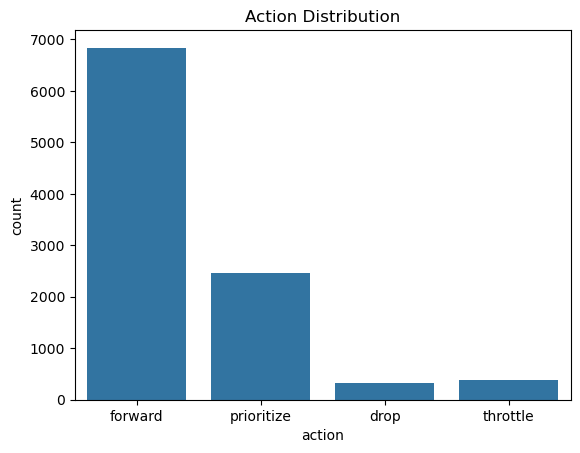

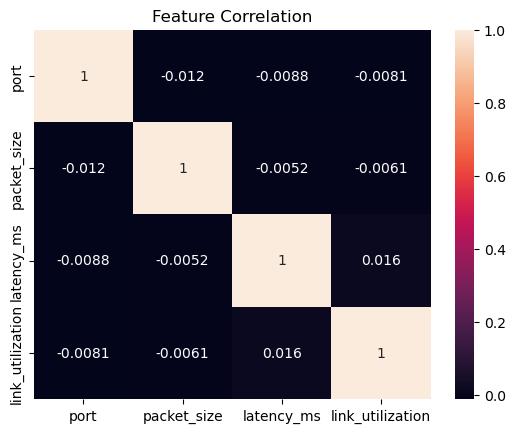

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count of each action
sns.countplot(data=df, x='action')
plt.title("Action Distribution")
plt.show()

# Correlation heatmap
sns.heatmap(df.drop(columns=['action']).select_dtypes(include='number').corr(), annot=True)
plt.title("Feature Correlation")
plt.show()


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load the dataset
df = pd.read_csv("synthetic_packet_data.csv")

# Encode categorical features
df['device_type'] = df['device_type'].astype('category').cat.codes
df['time_of_day'] = df['time_of_day'].astype('category').cat.codes
df['protocol'] = df['protocol'].astype('category').cat.codes
df['action'] = LabelEncoder().fit_transform(df['action'])  # e.g., 0=drop, 1=forward, ...

# Split features and target
X = df.drop(columns=['action'])
y = df['action']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

logreg = LogisticRegression(max_iter=500)
logreg.fit(X_train_scaled, y_train)
y_pred_log = logreg.predict(X_test_scaled)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))


Logistic Regression Accuracy: 0.9716666666666667
              precision    recall  f1-score   support

           0       0.90      0.66      0.77        86
           1       0.98      0.99      0.98      2029
           2       0.99      1.00      0.99       767
           3       0.80      0.75      0.77       118

    accuracy                           0.97      3000
   macro avg       0.92      0.85      0.88      3000
weighted avg       0.97      0.97      0.97      3000



In [5]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.9756666666666667
              precision    recall  f1-score   support

           0       0.96      0.74      0.84        86
           1       0.98      0.99      0.98      2029
           2       0.99      1.00      1.00       767
           3       0.79      0.77      0.78       118

    accuracy                           0.98      3000
   macro avg       0.93      0.88      0.90      3000
weighted avg       0.98      0.98      0.98      3000



Random Forest Accuracy: 0.9993333333333333
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        86
           1       1.00      1.00      1.00      2029
           2       1.00      1.00      1.00       767
           3       0.98      1.00      0.99       118

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



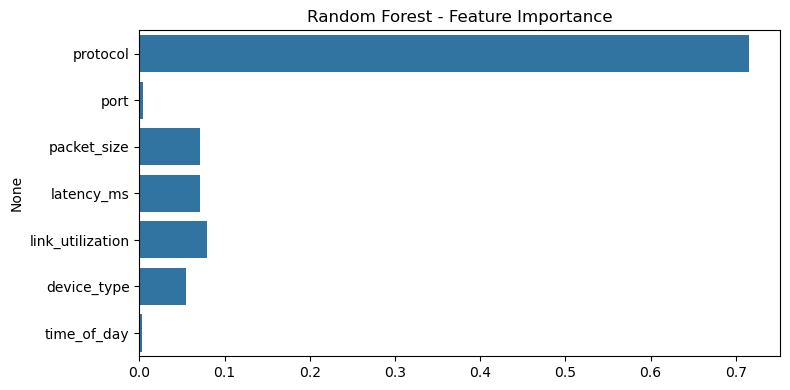

In [6]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Feature importances
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.barplot(x=rf.feature_importances_, y=X.columns)
plt.title("Random Forest - Feature Importance")
plt.tight_layout()
plt.show()


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Encode string labels to integers
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(df['action'])

# One-hot encode the labels for Keras
y_categorical = to_categorical(y_encoded)

# Reuse previously scaled X
X_train, X_test, y_train_enc, y_test_enc = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential()
model.add(Dense(32, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(y_train_enc.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(
    X_train_scaled, y_train_enc,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/10


c:\Users\Renan\anaconda3\envs\api\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6587 - loss: 0.9397 - val_accuracy: 0.9450 - val_loss: 0.2729
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9300 - loss: 0.2639 - val_accuracy: 0.9538 - val_loss: 0.1380
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9502 - loss: 0.1390 - val_accuracy: 0.9675 - val_loss: 0.0921
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9615 - loss: 0.0980 - val_accuracy: 0.9737 - val_loss: 0.0720
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9713 - loss: 0.0745 - val_accuracy: 0.9762 - val_loss: 0.0586
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9811 - loss: 0.0601 - val_accuracy: 0.9812 - val_loss: 0.0530
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9824 - loss: 0.0513 - val_accuracy: 0.9787 - val_loss: 0.0469
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9828 - loss: 0.0482 - val_accuracy: 0.9850 - val_

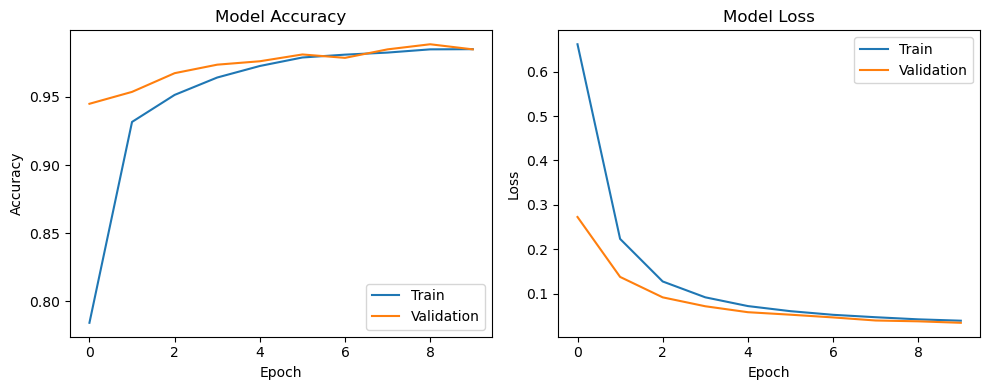

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Predictions from DNN
y_pred_dnn = model.predict(X_test_scaled)
y_pred_labels = np.argmax(y_pred_dnn, axis=1)
y_true_labels = np.argmax(y_test_enc, axis=1)

# Defensive fix: handle case where encoder.classes_ is broken
try:
    target_names = list(map(str, encoder.classes_))
except:
    target_names = [str(i) for i in sorted(np.unique(y_true_labels))]

# Print report
print("Shallow DNN Accuracy:", accuracy_score(y_true_labels, y_pred_labels))
print(classification_report(y_true_labels, y_pred_labels, target_names=target_names))


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Shallow DNN Accuracy: 0.9815
              precision    recall  f1-score   support

           0       0.95      0.90      0.92        58
           1       0.98      0.99      0.99      1355
           2       1.00      1.00      1.00       509
           3       0.84      0.78      0.81        78

    accuracy                           0.98      2000
   macro avg       0.94      0.92      0.93      2000
weighted avg       0.98      0.98      0.98      2000



In [10]:
import time

start = time.time()
_ = logreg.predict(X_test_scaled)
print("Logistic Regression Inference Time:", time.time() - start, "seconds")

start = time.time()
_ = svm.predict(X_test_scaled)
print("SVM Inference Time:", time.time() - start, "seconds")

start = time.time()
_ = model.predict(X_test_scaled)
end = time.time()
print("DNN Inference Time:", end - start, "seconds")

Logistic Regression Inference Time: 0.0010063648223876953 seconds
SVM Inference Time: 0.015277862548828125 seconds
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step
DNN Inference Time: 0.09089136123657227 seconds


In [31]:
# Explicit label mapping to match ML encoding
label_map = {
    'drop': 0,
    'forward': 1,
    'prioritize': 2,
    'throttle': 3
}

# Improved rule logic
def apply_llm_policy(row):
    # Extended video-related ports
    video_ports = [80, 443, 8080, 1935, 554, 1755]

    # Policy P1: Prioritize video/web during business hours (morning + afternoon)
    if row['protocol'] == 'TCP' and row['port'] in video_ports and row['time_of_day'] in ['morning', 'afternoon']:
        return label_map['prioritize']
    
    # Policy P2: Drop unregistered IoT with high latency
    if row['device_type'] == 'unregistered_IoT' and row['latency_ms'] > 100:
        return label_map['drop']
    
    # Policy P3: Throttle bulk transfers on congested link
    if row['packet_size'] > 1000 and row['link_utilization'] > 0.85:
        return label_map['throttle']
    
    # Policy P4: Prioritize DNS traffic
    if row['protocol'] == 'DNS' or row['port'] == 53:
        return label_map['prioritize']
    
    # Default action
    return label_map['forward']

# Apply rule logic only to the test set
X_test_with_index['rule_action'] = X_test_with_index.apply(apply_llm_policy, axis=1)


In [32]:
# Combine X_test and original df to get raw values for rule logic
X_test_with_index = X.loc[X_test.index].copy()

# Reattach original non-scaled features (needed for apply_llm_policy)
X_test_with_index['device_type'] = df.loc[X_test.index, 'device_type']
X_test_with_index['protocol'] = df.loc[X_test.index, 'protocol']
X_test_with_index['port'] = df.loc[X_test.index, 'port']
X_test_with_index['latency_ms'] = df.loc[X_test.index, 'latency_ms']
X_test_with_index['packet_size'] = df.loc[X_test.index, 'packet_size']
X_test_with_index['link_utilization'] = df.loc[X_test.index, 'link_utilization']
X_test_with_index['time_of_day'] = df.loc[X_test.index, 'time_of_day']

# Apply the rule logic only to the X_test subset
X_test_with_index['rule_action'] = X_test_with_index.apply(apply_llm_policy, axis=1)



In [33]:
from sklearn.metrics import accuracy_score

# Convert model predictions to class labels
y_pred_dnn = model.predict(X_test_scaled)
y_pred_labels = np.argmax(y_pred_dnn, axis=1)

# Use inverse_transform to convert ints → string labels
ml_predicted_actions = encoder.inverse_transform(y_pred_labels)

# Add predictions to the same DataFrame
X_test_with_index['ml_action'] = ml_predicted_actions

# Compare ML predictions with rule-based actions
X_test_with_index['match'] = X_test_with_index['rule_action'] == X_test_with_index['ml_action']
agreement_rate = X_test_with_index['match'].mean()

print(f"Agreement between ML model and LLM rules: {agreement_rate:.2%}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step
Agreement between ML model and LLM rules: 61.35%


In [34]:
# Add ML predictions if not already added
X_test_with_index['ml_action'] = y_pred_labels

# Compare
X_test_with_index['match'] = X_test_with_index['ml_action'] == X_test_with_index['rule_action']
agreement_rate = X_test_with_index['match'].mean()

print(f"Agreement between ML model and improved LLM rules: {agreement_rate:.2%}")

Agreement between ML model and improved LLM rules: 61.35%


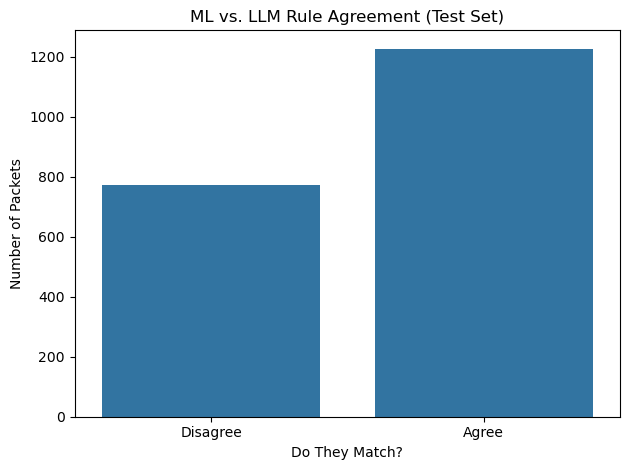

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=X_test_with_index, x='match')
plt.title("ML vs. LLM Rule Agreement (Test Set)")
plt.xlabel("Do They Match?")
plt.ylabel("Number of Packets")
plt.xticks([0, 1], ['Disagree', 'Agree'])
plt.tight_layout()
plt.show()

In [35]:
# Label map for action encoding
label_map = {
    0: 'drop',
    1: 'forward',
    2: 'prioritize',
    3: 'throttle'
}

# Encoded categorical features
protocol_map = {'TCP': 1, 'UDP': 2, 'DNS': 3, 'ICMP': 4}
device_type_map = {'registered_IoT': 0, 'unregistered_IoT': 1, 'mobile': 2, 'server': 3}
time_of_day_map = {'morning': 0, 'afternoon': 1, 'evening': 2, 'night': 3}

# Simulation function
def simulate_packet_action(packet):
    protocol = protocol_map.get(packet['protocol'], -1)
    device_type = device_type_map.get(packet['device_type'], -1)
    time_of_day = time_of_day_map.get(packet['time_of_day'], -1)

    latency = packet['latency_ms']
    port = packet['port']
    packet_size = packet['packet_size']
    link_utilization = packet['link_utilization'] * 100  # Convert to %
    
    # LLM-derived rule logic
    if device_type == 1 and latency > 100:
        return label_map[0]  # drop
    elif packet_size > 1000 and link_utilization > 85:
        return label_map[3]  # throttle
    elif protocol == 3 or port == 53:
        return label_map[2]  # prioritize
    elif protocol == 1 and port in [80, 443, 8080, 1935, 554, 1755] and time_of_day in [0, 1]:
        return label_map[2]  # prioritize
    else:
        return label_map[1]  # forward


In [36]:
# Simulate a packet
sample_packet = {
    'protocol': 'TCP',
    'device_type': 'unregistered_IoT',
    'latency_ms': 120,
    'port': 443,
    'packet_size': 800,
    'link_utilization': 0.42,
    'time_of_day': 'morning'
}

action = simulate_packet_action(sample_packet)
print(f"Packet action: {action}")  # Expected: 'drop'


Packet action: drop


In [37]:
# Must ensure original feature values are in X_test_with_index
X_test_with_index['simulated_action'] = X_test_with_index.apply(lambda row: simulate_packet_action({
    'protocol': df.loc[row.name, 'protocol'],
    'device_type': df.loc[row.name, 'device_type'],
    'latency_ms': df.loc[row.name, 'latency_ms'],
    'port': df.loc[row.name, 'port'],
    'packet_size': df.loc[row.name, 'packet_size'],
    'link_utilization': df.loc[row.name, 'link_utilization'],
    'time_of_day': df.loc[row.name, 'time_of_day']
}), axis=1)


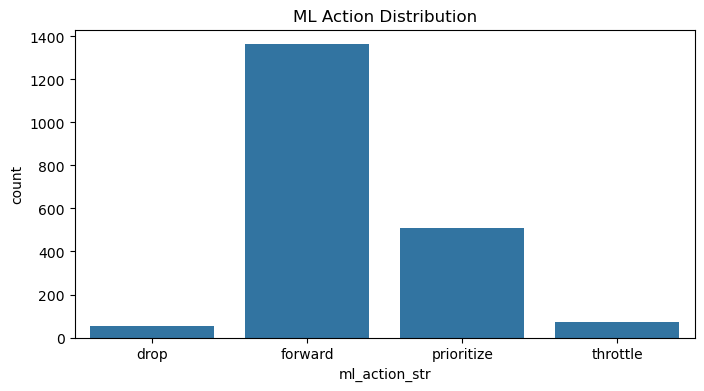

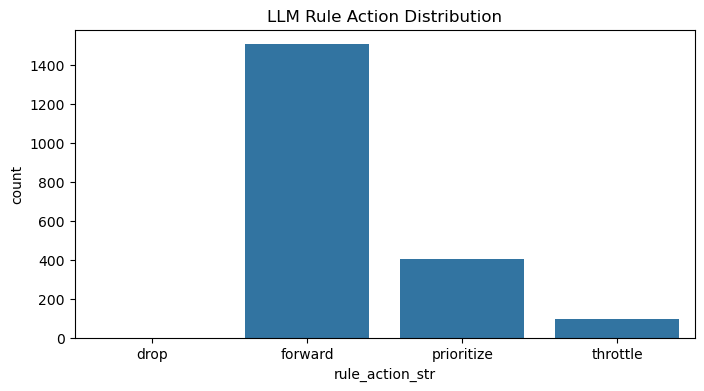

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Map numeric actions to string labels if needed
label_map_reverse = {0: 'drop', 1: 'forward', 2: 'prioritize', 3: 'throttle'}

X_test_with_index['ml_action_str'] = [label_map_reverse[i] for i in X_test_with_index['ml_action']]
X_test_with_index['rule_action_str'] = [label_map_reverse[i] for i in X_test_with_index['rule_action']]

plt.figure(figsize=(8, 4))
sns.countplot(data=X_test_with_index, x='ml_action_str', order=['drop', 'forward', 'prioritize', 'throttle'])
plt.title("ML Action Distribution")
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(data=X_test_with_index, x='rule_action_str', order=['drop', 'forward', 'prioritize', 'throttle'])
plt.title("LLM Rule Action Distribution")
plt.show()


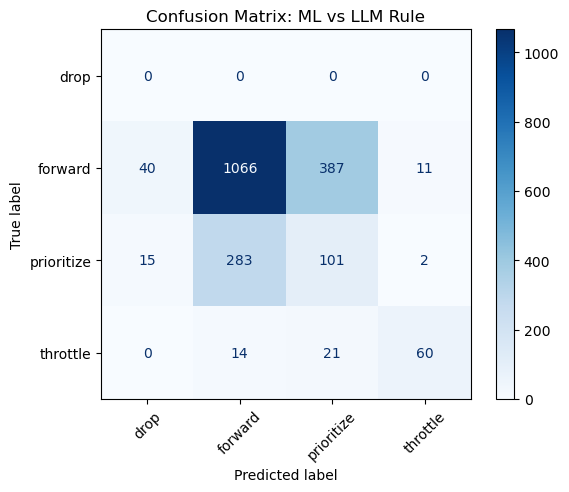

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(X_test_with_index['rule_action'], X_test_with_index['ml_action'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['drop', 'forward', 'prioritize', 'throttle'])
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix: ML vs LLM Rule")
plt.show()
